In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from astropy.table import Table
import astropy.io.fits as fits

from scipy.optimize import curve_fit

from glob import glob

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

from astropy.stats import LombScargle
from stuff import FINDflare

In [3]:
tess_dir = '/data/epyc/data/tess/'

sectors = ['sector001', 'sector002']

# just in case glob wants to re-order things, be sure grab them in Sector order
sect1 = glob(tess_dir + sectors[0] + '/*.fits', recursive=True)
sect2 = glob(tess_dir + sectors[1] + '/*.fits', recursive=True)

files = sect1 + sect2
print(len(sect1), len(sect2), len(files))

15889 15990 31879


In [4]:
%%time
per_out = np.zeros(len(files)) -1 
per_amp = np.zeros(len(files)) -1 

FL_id = np.array([])
FL_t0 = np.array([]) 
FL_t1 = np.array([])
FL_f0 = np.array([])
FL_f1 = np.array([])

for k in range(len(files)):
    try:
        tbl = Table.read(files[k], format='fits')
        df = tbl.to_pandas()
        AOK = tbl['QUALITY'] == 0
        if sum(AOK) > 10:
            smo = df['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()
            med = np.nanmedian(smo)
            SOK = np.isfinite(smo)

            FL = FINDflare((df['PDCSAP_FLUX'][AOK][SOK] - smo[SOK])/med, df['PDCSAP_FLUX_ERR'][AOK][SOK]/med, 
                           N1=3, N2=1, N3=3)


            LS = LombScargle(df['TIME'][AOK][SOK], smo[SOK]/med, dy=df['PDCSAP_FLUX_ERR'][AOK][SOK]/med)
            frequency, power = LS.autopower(minimum_frequency=1./20., maximum_frequency=1./0.1)
            best_frequency = frequency[np.argmax(power)]

            per_out[k] = 1./best_frequency
            per_amp[k] = np.nanmax(power)

            if np.size(FL) > 0:
                for i in range(len(FL[0])):
                    FL_id = np.append(FL_id, k)
                    FL_t0 = np.append(FL_t0, FL[0][i])
                    FL_t1 = np.append(FL_t1, FL[1][i])
                    FL_f0 = np.append(FL_f0, med)
                    FL_f1 = np.append(FL_f1, np.nanmax(tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)]))


            # make output plots?
            if False:
                plt.figure(figsize=(12,9))
                plt.errorbar(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK], yerr=tbl['PDCSAP_FLUX_ERR'][AOK], 
                             linestyle=None, alpha=0.25, label='PDCFLUX')

                plt.plot(tbl['TIME'][AOK], smo, label='128pt MED')
                if np.size(FL) > 0:
                    for i in range(len(FL[0])):
                        plt.scatter(tbl['TIME'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], 
                                    tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], color='r', label='_nolegend_')

                if np.nanmax(power) > 0.25:
                    LSmodel = LS.model(df['TIME'][AOK][SOK], best_frequency)
                    plt.plot(df['TIME'][AOK][SOK], LSmodel * med, label='P='+format(1./best_frequency, '6.3f')+'d')            

                plt.title(files[k].split('/')[-1], fontsize=12)
                plt.ylabel('Flux')
                plt.xlabel('MJD')
                plt.legend(fontsize=12)
                plt.show()
                # plt.savefig('test1.jpeg', bbox_inches='tight', pad_inches=0.25)
    except (OSError, KeyError, TypeError):
        print('k=' + str(k) + ' bad file: ' + files[k])

k=3309 bad file: /data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000139804925-0120-s_lc.fits
k=4172 bad file: /data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000147302681-0120-s_lc.fits
k=11729 bad file: /data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000302335313-0120-s_lc.fits
k=13694 bad file: /data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000372909708-0120-s_lc.fits
k=15324 bad file: /data/epyc/data/tess/sector001/tess2018206045859-s0001-0000000425878763-0120-s_lc.fits


k=15951 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000005641875-0121-s_lc.fits
k=17161 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000032035258-0121-s_lc.fits
k=18936 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000070785900-0121-s_lc.fits
k=21639 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000160196600-0121-s_lc.fits
k=22726 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000183587877-0121-s_lc.fits
k=25455 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000232075203-0121-s_lc.fits
k=26732 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000260507093-0121-s_lc.fits
k=29765 bad file: /data/epyc/data/tess/sector002/tess2018234235059-s0002-0000000350621525-0121-s_lc.fits
CPU times: user 1d 20h 30min 9s, sys: 3h 49min 44s, total: 2d 19min 53s
Wall time: 2h 47min 33s


Text(0,0.5,'# stars')

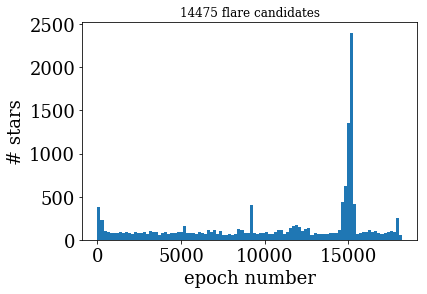

In [5]:
_ = plt.hist((FL_t0+FL_t1)/2.,bins=100)

plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')

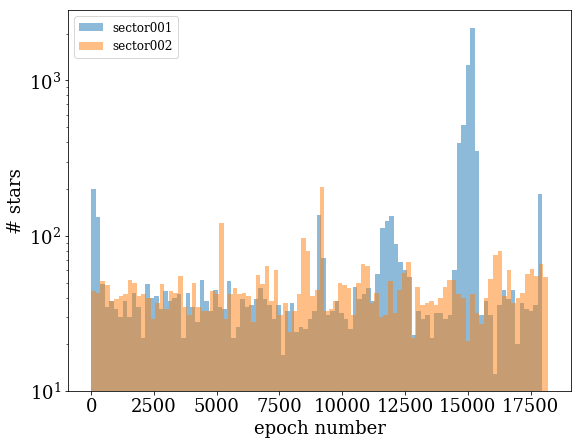

In [85]:
plt.figure(figsize=(9,7))
s1 = np.where((FL_id < 15000))[0]
s2 = np.where((FL_id > 16000))[0]

_ = plt.hist((FL_t0[s1]+FL_t1[s1])/2.,bins=100, alpha=0.5, label='sector001')
_ = plt.hist((FL_t0[s2]+FL_t1[s2])/2.,bins=100, alpha=0.5, label='sector002')

# plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')
plt.legend(fontsize=12)
plt.yscale('log')
plt.savefig('flare_hist.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5,1,'13803 stars w/ LS>0.2')

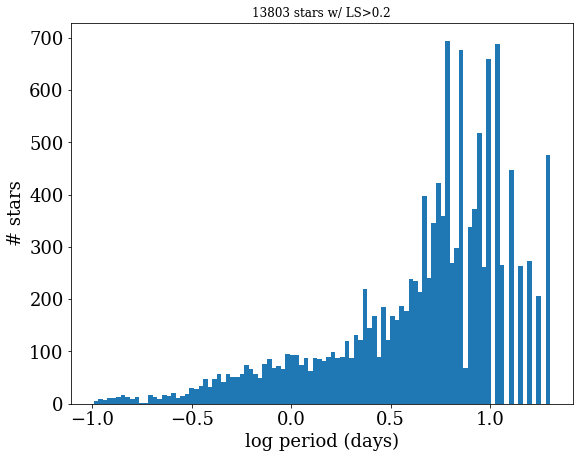

In [7]:
plt.figure(figsize=(9,7))

ok = np.where((per_amp > 0.2))[0]
_ = plt.hist(np.log10(per_out[ok]), bins=100)

plt.xlabel('log period (days)')
plt.ylabel('# stars')
plt.title(str(np.size(ok)) + ' stars w/ LS>0.2',fontsize=12)


In [8]:
ALL_TIC = pd.Series(files).str.split('-', expand=True).iloc[:,-3].astype('int')

In [9]:
flare_out = pd.DataFrame(data={'TIC':ALL_TIC[FL_id], 'i0':FL_t0, 'i1':FL_t1, 'med':FL_f0, 'peak':FL_f1})
flare_out.to_csv('flare_out_v01.csv')

In [10]:
rot_out = pd.DataFrame(data={'TIC':ALL_TIC, 
                             'per':per_out, 'amp':per_amp})
rot_out.to_csv('rot_out_v01.csv')

In [ ]:
# NOW MATCH OUTPUT TO GAIA FILE, PLOT ROTATION ON THE CMD, AND PROT VS COLOR

In [16]:
df1 = pd.read_csv(tess_dir + 'gaiatess1_xmatch_1arsec-result.csv')
df2 = pd.read_csv(tess_dir + 'gaiatess2_xmatch_1arsec-result.csv')

In [17]:
df = pd.concat([df1, df2], ignore_index=True, sort=False)

(29684, 112)

In [23]:
gdata = pd.merge(df, rot_out, right_on='TIC', left_on='ticid')

In [25]:
gdata.columns.values

array(['solution_id', 'designation', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr',
       'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al',
       'astrometric_n_obs_ac', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_gof_al',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object

In [28]:
ok = np.where(np.isfinite(gdata[u'parallax']) & # this is basically the same as the TGAS file...
              (gdata[u'parallax_error'] < 0.1) &
              (gdata[u'modality_flag'] == 1) & 
              (gdata[u'result_flag'] == 1) &
              np.isfinite(gdata[u'bp_rp']) & 
              (gdata[u'phot_bp_mean_flux_error']/gdata[u'phot_bp_mean_flux'] < 0.01) & 
              (gdata[u'phot_rp_mean_flux_error']/gdata[u'phot_rp_mean_flux'] < 0.01) & 
              (gdata[u'phot_g_mean_flux_error']/gdata[u'phot_g_mean_flux'] < 0.01) & 
              (gdata['per'] > 0.1) & 
              (gdata['amp'] > 0.25))[0]
print(ok.shape)

(13234,)


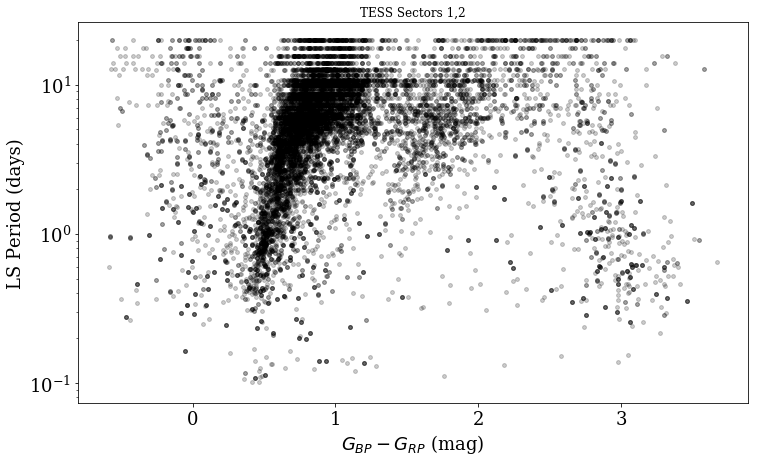

In [51]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=15, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
plt.savefig('color_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5,1,'TESS Sectors 1,2')

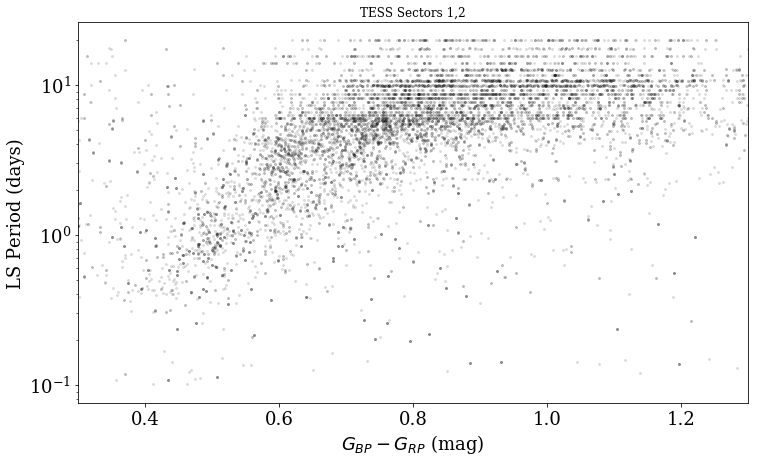

In [83]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=4, alpha=0.1, c='k')
plt.yscale('log')
plt.xlim(0.3,1.3)
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
# plt.savefig('color_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


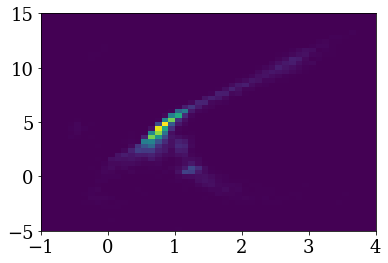

In [77]:
cb,xeb,yeb,ib = plt.hist2d(gdata['bp_rp'], 
                           gdata['phot_g_mean_mag'] - 5. * np.log10(gdata[u'r_est'].values) + 5, 
                           range=[[-1,4],[-5,15]], bins=(50,50))

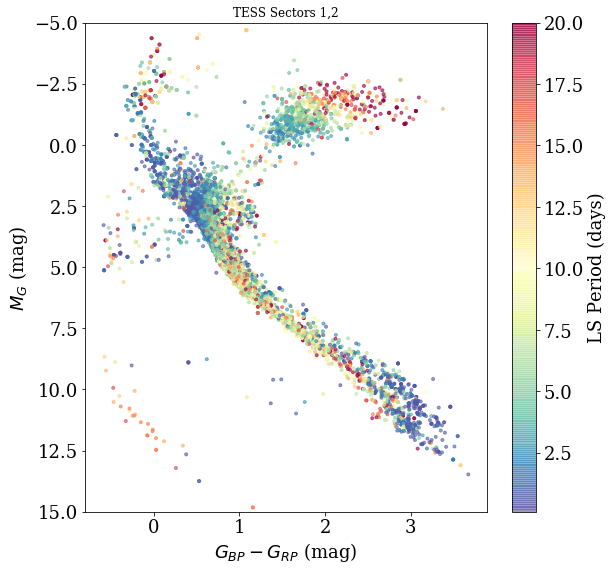

In [80]:

plt.figure(figsize=(9,9))


# plt.contour(cb.T, extent=[xeb.min(),xeb.max(),yeb.min(),yeb.max()], levels=[0.1,1,10,100], colors='k', alpha=0.5)

plt.scatter(gdata['bp_rp'][ok], gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok]), cmap=plt.cm.Spectral_r)

cbar = plt.colorbar()
cbar.set_label('LS Period (days)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.title('TESS Sectors 1,2', fontsize=12)
plt.ylim(15,-5)
plt.savefig('cmd_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

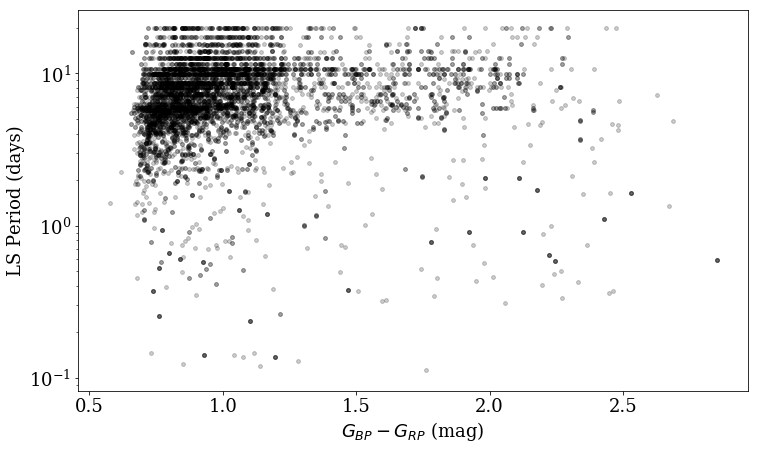

In [57]:
msbad = np.where((gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 > 4) & 
                 (gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 < 9) & 
                 (gdata['bp_rp'][ok] > 0.5))[0]

plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok[msbad]], gdata['per'].values[ok[msbad]], s=15, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.title('TESS Sectors 1,2', fontsize=12)
plt.savefig('color_per2.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [60]:
print(np.shape(msbad))

(6686,)


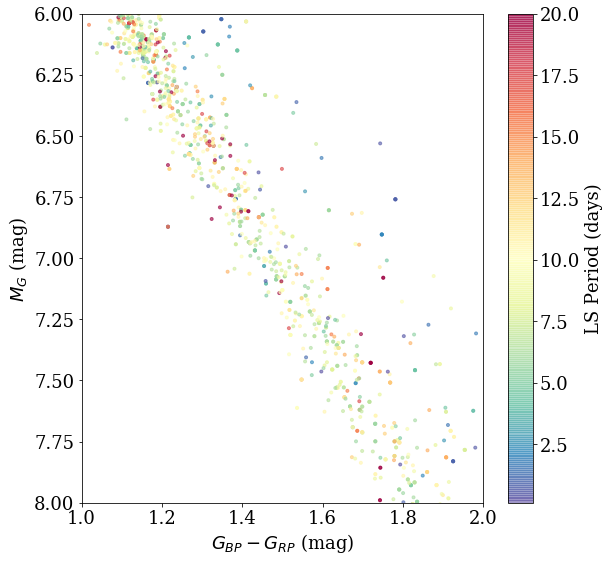

In [61]:

plt.figure(figsize=(9,9))

plt.scatter(gdata['bp_rp'][ok[msbad]], gdata['phot_g_mean_mag'][ok[msbad]] - 5. * np.log10(gdata[u'r_est'].values[ok[msbad]]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok[msbad]]), cmap=plt.cm.Spectral_r)

cb = plt.colorbar()
cb.set_label('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.title('TESS Sectors 1,2', fontsize=12)
plt.ylim(8,6)
plt.xlim(1,2)
plt.savefig('cmd_per2.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [63]:
%pwd

'/data/epyc/users/jrad'